# Intro
For background explanations on this example, see Section IV of "Blueprint for Next Generation Cyber-Physical Resilience using Defense Quantum Machine Learning"

## state diagram:

![Train Network Graph](QML_Thesis_TrainDiagram_Oct21.png)

## Importing Libraries
/initializing

In [51]:
import pennylane as qml
from   pennylane import numpy as np
from   pennylane.optimize import NesterovMomentumOptimizer as nmOptimizer
import matplotlib.pyplot as plt

import math
import random
from   typing import List

np.random.seed(0)

# Constants
# actions defined
LOOP   = 0
BYPASS = 1

# For the current problem we have 5 potential states,
numStates  = 5
# at least 3 cubits is needed to index the environment
numQubits  = 3
numActions = 2

# Markov Decision Process

## Create the MDP environment

In [52]:
def createMDP(correlation: float) -> tuple[List[List[List[float]]], List[List[List[float]]]]:
  """Generates the transition and the reward matrices for
  our scenarios MDP based on correlation

  Args:
      correlation (double): how corrilated train 2's choice
      of move is to that of train 1. element from -1 to 1.

  Returns:
      t: MDP's transition matrix
      r: MDP's reward matrix
  """
  if correlation < -1 or correlation > 1:
    return False

  # The math is much simpler when we change from correlation to prob
  # like this
  c = (correlation + 1) / 2

  t = np.zeros((numStates, numStates, numActions))
  r = np.zeros((numStates, numStates, numActions))

  # STATE 0
  # Loop
  # train 1: loop, train 2: loop 
  t[0][0][LOOP]   = c     # From state 0 to state 0
  r[0][0][LOOP]   = 0     # reward(state 0) = 0
  # train 1: loop, train 2: bypass
  t[0][1][LOOP]   = 1-c   # From state 0 to state 1
  r[0][1][LOOP]   = 4     # reward(state 1) = 4
  # Bypass
  # train 1: bypass, train 2: loop
  t[0][2][BYPASS] = 1-c # From state 0 to state 2
  r[0][2][BYPASS] = 2   # reward(state 2) = 2
  # train 1: bypass, train 2: bypass
  t[0][0][BYPASS] = c   # From state 0 to state 0 
  r[0][0][BYPASS] = 0   # reward(state 0) = 0

  # STATE 1
  # Loop
  # train 1: loop, train 2: loop
  t[1][1][LOOP]   = c     # From state 1 to state 1
  r[1][1][LOOP]   = 4     # reward(state 1) = 4
  # train 1: loop, train 2: [short, loop]
  t[1][4][LOOP]   = (1-c)*c # From state 1 to state 4
  r[1][4][LOOP]   = 4     # reward(state 4) = 4
  # train 1: loop, train 2: [short, short]
  t[1][3][LOOP]   = (1-c)*(1-c) # From state 1 to state 3
  r[1][3][LOOP]   = 2     # reward(state 3) = 2
  # Bypass
  # train 1: Bypass, train 2: loop
  t[1][0][BYPASS] = 1-c   # From state 1 to state 0
  r[1][0][BYPASS] = 0     # reward(state 0) = 0
  # train 1: Bypass, train 2: Bypass
  t[1][1][BYPASS] = c     # From state 1 to state 1
  r[1][1][BYPASS] = 4     # reward(state 4) = 4

  # STATE 2
  # Loop
  # train 1: loop, train 2: loop 
  t[2][2][LOOP]   = c     # From state 2 to state 2
  r[2][2][LOOP]   = 2     # reward(state 2) = 2
  # train 1: loop, train 2: bypass
  t[2][0][LOOP]   = 1-c   # From state 2 to state 0
  r[2][0][LOOP]   = 0     # reward(state 0) = 0
  # Bypass
  # train 1: bypass, train 2: loop
  t[2][4][BYPASS] = 1-c   # From state 2 to state 0
  r[2][4][BYPASS] = 4     # reward(state 4) = 4
  # train 1: bypass, train 2: bypass
  t[2][2][BYPASS] = c     # From state 2 to state 2
  r[2][2][BYPASS] = 2     # reward(state 2) = 2

  # STATE 3 
  # Loop
  # train 1: loop, train 2: loop
  t[3][2][LOOP]   = c     # From state 3 to state 2
  r[3][2][LOOP]   = 2     # reward(state 2) = 2
  # train 1: loop, train 2: bypass
  t[3][0][LOOP]   = 1-c   # From state 3 to state 0
  r[3][0][LOOP]   = 0     # reward(state 0) = 0
  # Bypass
  # train 1: bypass, train 2: loop
  t[3][3][BYPASS] = 1-c   # From state 3 to state 3
  r[3][3][BYPASS] = 2     # reward(state 3) = 2
  # train 1: bypass, train 2: bypass
  t[3][4][BYPASS] = c     # From state 3 to state 4
  r[3][4][BYPASS] = 4     # reward(state 4) = 4

  # STATE 4
  # Loop
  # train 1: loop, train 2: loop
  t[4][4][LOOP]   = c     # From state 4 to state 4
  r[4][4][LOOP]   = 4     # reward(state 4) = 4
  # train 1: loop, train 2: bypass
  t[4][3][LOOP]   = 1-c   # From state 4 to state 3
  r[4][3][LOOP]   = 2     # reward(state 3) = 2
  # Bypass (train 2 does not reach the bypass)
  # train 1: bypass, train 2: null
  t[4][1][BYPASS] = 1     # From state 4 to state 1
  r[4][1][BYPASS] = 4     # reward(state 1) = 4

  return t, r


transitions, rewards = createMDP(0)

# Quantum Reinforcement Learning

## Create the quantum device

In [53]:
dev = qml.device('default.qubit', wires=numQubits)

## Create the circuit for the variational classifier.

In [54]:
@qml.qnode(dev)
def circuit(theta: List[List[int]], state: int = 0) -> float:
  # Representing state in quantum form
  for i in range(numQubits)[::-1]:
    if state % 2 == 1:
      qml.RX(math.pi, wires=i)
      state -= 1
    state //= 2
  #return qml.probs(wires=[0,1,2]) #Check quantum represtentation
  
  # Circuit
  qml.Rot(theta[0,0], theta[0,1], 0, wires=0)#theta[0,2], wires=0)
  qml.Rot(theta[1,0], theta[1,1], 0, wires=1)#theta[1,2], wires=1)
  qml.Rot(theta[2,0], theta[2,1], 0, wires=2)#theta[2,2], wires=2)

  qml.CNOT(wires=[0,1])
  qml.CNOT(wires=[1,2])
  qml.CNOT(wires=[2,0])

  qml.Rot(theta[0,0], theta[0,1], 0, wires=0)

  # Return likelyhood of each action
  return qml.probs(wires=0)#[numQubits-1])

## Cost Model

In [55]:
def squareLoss(measurements: List[float], qValues: List[float]) -> float:
  # qRatios = [
  #   qValues[0] / (qValues[0] + qValues[1]),
  #   qValues[1] / (qValues[0] + qValues[1])
  # ]
  qRatios = [
    1 if qValues[0] > qValues[1] else 0,
    1 if qValues[1] > qValues[0] else 0
  ]

  loss = 0
  for m, q in zip(measurements, qRatios):
    loss += (m-q)**2
  
  #print(f"qValues={qValues}\t|\tqRatios={qRatios}\t|\tmeasure={measurements}\t|\tloss={loss}")
  
  return loss / min(len(measurements), len(qRatios))

# def cost(theta: List[List[int]], qTable: List[List[int]], state: int) -> float:
#   return squareLoss(circuit(theta), qTable[state])

def cost(theta: List[List[float]], stateList: List[int], qTable: List[List[float]]) -> float:
  totalLoss = 0
  #print(f"s={stateList[0]}, loss={squareLoss(circuit(theta, stateList[0]), qTable[stateList[0]])}, qbit={circuit(theta)}")
  for s in stateList:
    totalLoss += squareLoss(circuit(theta, s), qTable[s])
  #print(f"total loss:",totalLoss)
  return totalLoss #/ len(stateList)


## Quantum Circuit Update

In [56]:
# initialize optimizer. Using arbitrary stepsize for now
opt = qml.GradientDescentOptimizer(stepsize=0.5)
# set number of steps for state
steps = 10

# Epsilon
# should probably be refactored as non-global variables
epsilon       = 1.
epsilonDecay  = 0.05
epsilonMin    = 0.5

def update(theta: List[List[float]], qTable: List[List[float]], state: int, epsilon: float) -> List[List[float]]:
  curState = state

  stateList = []

  # simulate a step number of steps exploration
  for i in range(steps):
    # Take a step
    #theta = opt.step(lambda weights: cost(weights, qTable, curState), theta)

    # Take an action
    if random.random() < epsilon:
      # Take a random action
      action = LOOP if random.random() < 0.5 else BYPASS 
    else:
      # Take the action decided by the quantum circuit
      action = LOOP if random.random() < circuit(theta, curState)[0] else BYPASS
    
    # find new current state based on that action
    stateDistribution = transitions[curState, :, action]
    val = random.random()

    # record the state
    stateList.append(curState) 

    for j in range(len(stateDistribution)):
      val -= stateDistribution[j]
      if val <= 0:
        curState = j
        break
    
  #print(choiceRecords)
  theta = opt.step(lambda weights: cost(weights, stateList, qTable), theta)

  epsilon = max(epsilon-epsilonDecay, epsilonMin)

  return theta, epsilon


## Initialize Weights

In [57]:
weights = np.random.rand(3,2)
initWeights = weights.copy()

## visualizing circuit

In [58]:
drawer = qml.draw(circuit)

print(drawer(weights))
print(circuit(weights, 1))
# |000>, |001>, |010>


 0: ──Rot(0.549, 0.715, 0)──╭C──────╭X──Rot(0.549, 0.715, 0)──┤ Probs 
 1: ──Rot(0.603, 0.545, 0)──╰X──╭C──│─────────────────────────┤       
 2: ──Rot(0.424, 0.646, 0)──────╰X──╰C────────────────────────┤       

[0.14713028 0.85286972]


## Reinforcement Learning Process

In [59]:
epochs = 100

# QTables(:,:,11) from matlab example | correlation 0
# table =  [
#   [4.9928, 3.8223],
#   [6.8271, 5.0471],
#   [3.5864, 6.3843],
#   [4.0652, 6.0729],
#   [6.6312, 7.5522]
# ]

# QTable(:,:,16) from matlab example | correlation 0.5
# table = [
#   [3.1180, 2.1667],
#   [7.4462, 6.1685],
#   [3.6492, 5.5486],
#   [4.1392, 5.5112],
#   [6.6909, 7.7249]
# ]

# QTable(:,:,20) from matlab example | correlation 0.9
table = [
  [0.7259, 0.4742],
  [7.9931, 7.7251],
  [3.9756, 4.4576],
  [3.3470, 1.4001],
  [7.8015, 7.9342]
]

initialState    = 0

totalCorrects   = []
loopActionProbs = [[] for i in range(numStates)]
loopActionLoss  = [[] for i in range(numStates)]

for i in range(epochs):
  initialState = random.randrange(0,4)
  weights, epsilon = update(weights, table, initialState, epsilon)
  print(f"epoch: {i}")
  print(drawer(weights))
  corrects = 0
  for j in range(numStates):
    qRatios = [1, 0] if table[j][0]>table[j][1] else [0, 1]
    qmlAction = circuit(weights, j)
    loopActionProbs[j].append(qmlAction[0])
    loopActionLoss[j].append(squareLoss(qmlAction, table[j]))
    correctGuess = abs(qRatios[0]-qmlAction[0]) < 0.5
    corrects += 1 if correctGuess else 0
    print(f"\tState({j}) QML={qmlAction} \t||\t QVals={qRatios} \t||\t {'X' if correctGuess else ''}")
  print(f"\tCorrects={corrects}")
  totalCorrects.append(corrects)
  print(np.around(abs(weights-initWeights), decimals=3))

print(f"Average Corrects={np.average(totalCorrects)}")
print(f"Max Corrects={max(totalCorrects)}")

epoch: 0
 0: ──Rot(0.775, -0.625, 0)──╭C──────╭X──Rot(0.775, -0.625, 0)──┤ Probs 
 1: ──Rot(0.603, -0.406, 0)──╰X──╭C──│──────────────────────────┤       
 2: ──Rot(0.424, 0.222, 0)───────╰X──╰C─────────────────────────┤       

	State(0) QML=[0.91171341 0.08828659] 	||	 QVals=[1, 0] 	||	 X
	State(1) QML=[0.18487406 0.81512594] 	||	 QVals=[1, 0] 	||	 
	State(2) QML=[0.08828659 0.91171341] 	||	 QVals=[0, 1] 	||	 X
	State(3) QML=[0.81512594 0.18487406] 	||	 QVals=[1, 0] 	||	 X
	State(4) QML=[0.81512594 0.18487406] 	||	 QVals=[0, 1] 	||	 
	Corrects=3
[[0.226 1.34 ]
 [0.    0.951]
 [0.    0.424]]
epoch: 1
 0: ──Rot(0.574, -2.12, 0)──╭C──────╭X──Rot(0.574, -2.12, 0)──┤ Probs 
 1: ──Rot(0.603, -1.44, 0)──╰X──╭C──│─────────────────────────┤       
 2: ──Rot(0.424, 0.512, 0)──────╰X──╰C────────────────────────┤       

	State(0) QML=[0.77178901 0.22821099] 	||	 QVals=[1, 0] 	||	 X
	State(1) QML=[0.83317456 0.16682544] 	||	 QVals=[1, 0] 	||	 X
	State(2) QML=[0.22821099 0.77178901] 	||	 QVals=[0

## Plotting

### Probs

state=0	|	loop


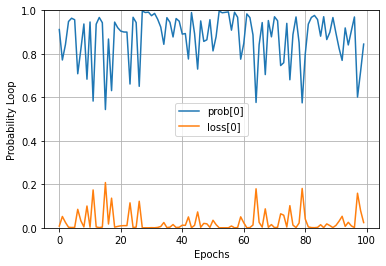

state=1	|	loop


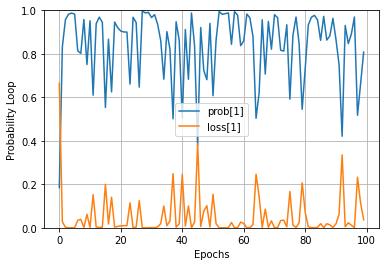

state=2	|	bypass


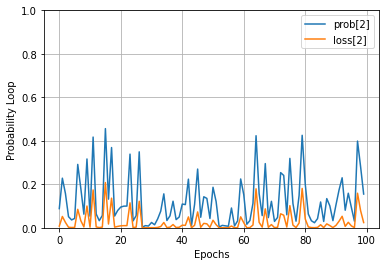

state=3	|	loop


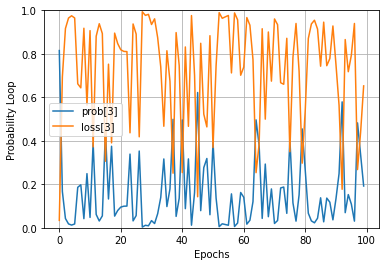

state=4	|	bypass


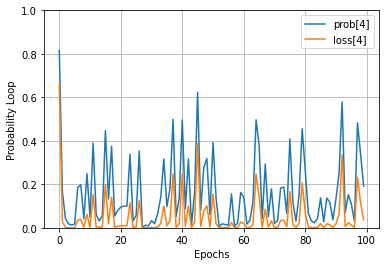

In [60]:
# for state in range(numStates):
# plt.plot(loopActionProbs[state], label=f'state[{state}]')
for state in range(numStates):
  print(f"state={state}\t|\t{'loop' if table[state][0]>table[state][1] else 'bypass'}")
  plt.plot(loopActionProbs[state],  label=f'prob[{state}]')
  plt.plot(loopActionLoss[state], label=f'loss[{state}]')

  plt.grid(True)
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Probability Loop")
  plt.ylim(0, 1)
  plt.show()